In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller #non-stationary and stationary
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30,5)
plt.rcParams['figure.dpi'] = 250
sns.set_style('darkgrid')
%matplotlib inline

Objective:
Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset. 


# Part 1: Data Preparation and Exploration

1.Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

In [2]:
df = pd.read_csv(r"C:\Users\Dell\Downloads\Timeseries\Timeseries\exchange_rate.csv",index_col=0, parse_dates=True)
df

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


In [3]:
df['Ex_rate']

date
01-01-1990 00:00    0.785500
02-01-1990 00:00    0.781800
03-01-1990 00:00    0.786700
04-01-1990 00:00    0.786000
05-01-1990 00:00    0.784900
                      ...   
06-10-2010 00:00    0.718494
07-10-2010 00:00    0.721839
08-10-2010 00:00    0.723197
09-10-2010 00:00    0.720825
10-10-2010 00:00    0.720825
Name: Ex_rate, Length: 7588, dtype: float64

2.Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

<Axes: xlabel='date'>

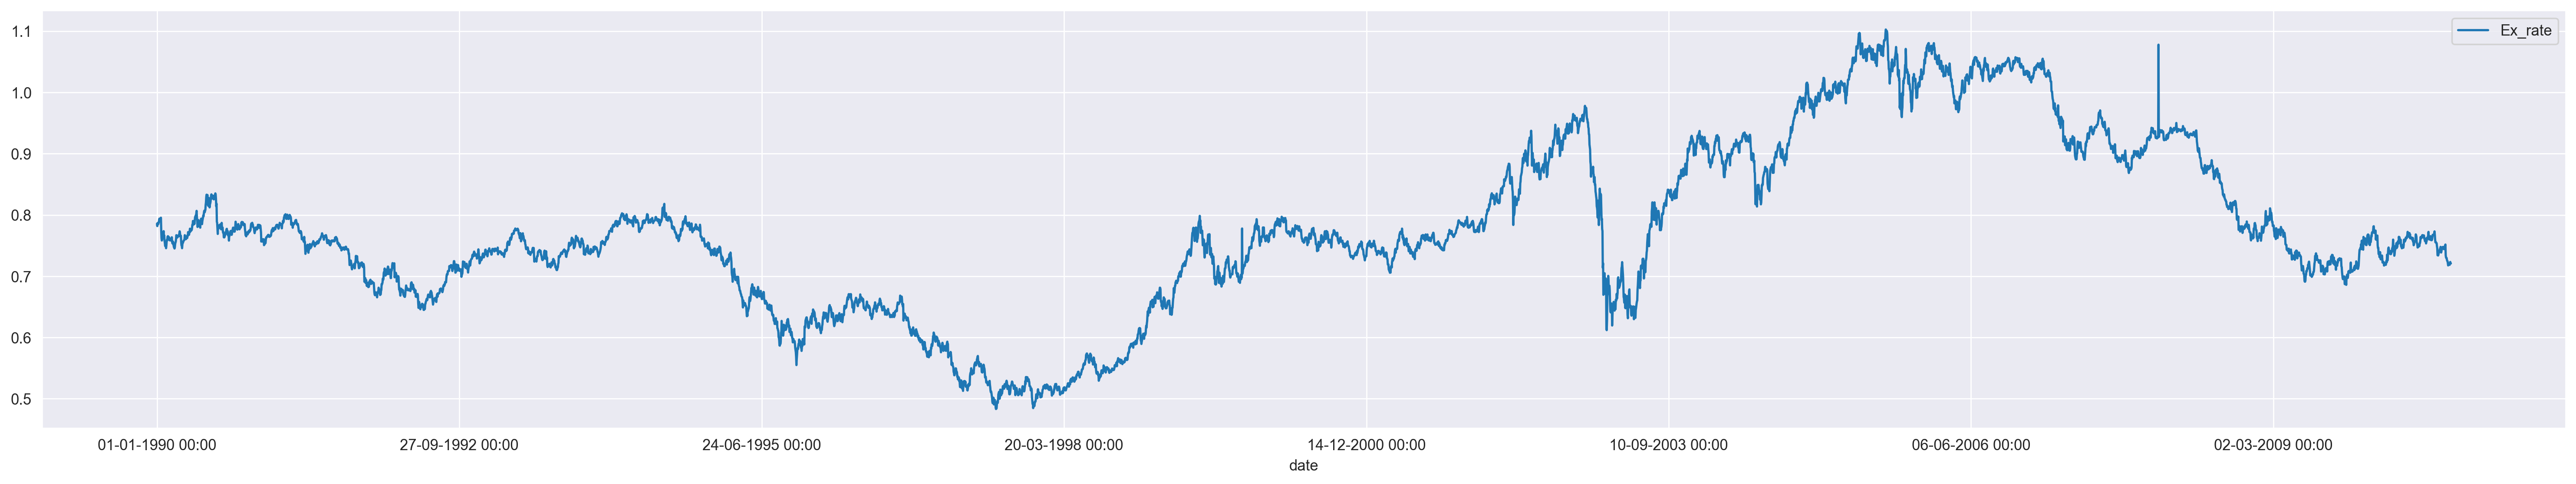

In [4]:
df.plot()

In [5]:
adfuller(df['Ex_rate'])[1]

0.44923273535979974

3.Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [6]:
# Check for missing values
print(df.isnull().sum())

# Fill or interpolate missing values if any
df['Ex_rate'].fillna(method='ffill', inplace=True)

# Verify there are no missing values
print(df.isnull().sum())

Ex_rate    0
dtype: int64
Ex_rate    0
dtype: int64


# Part 2: Model Building - ARIMA

1.Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

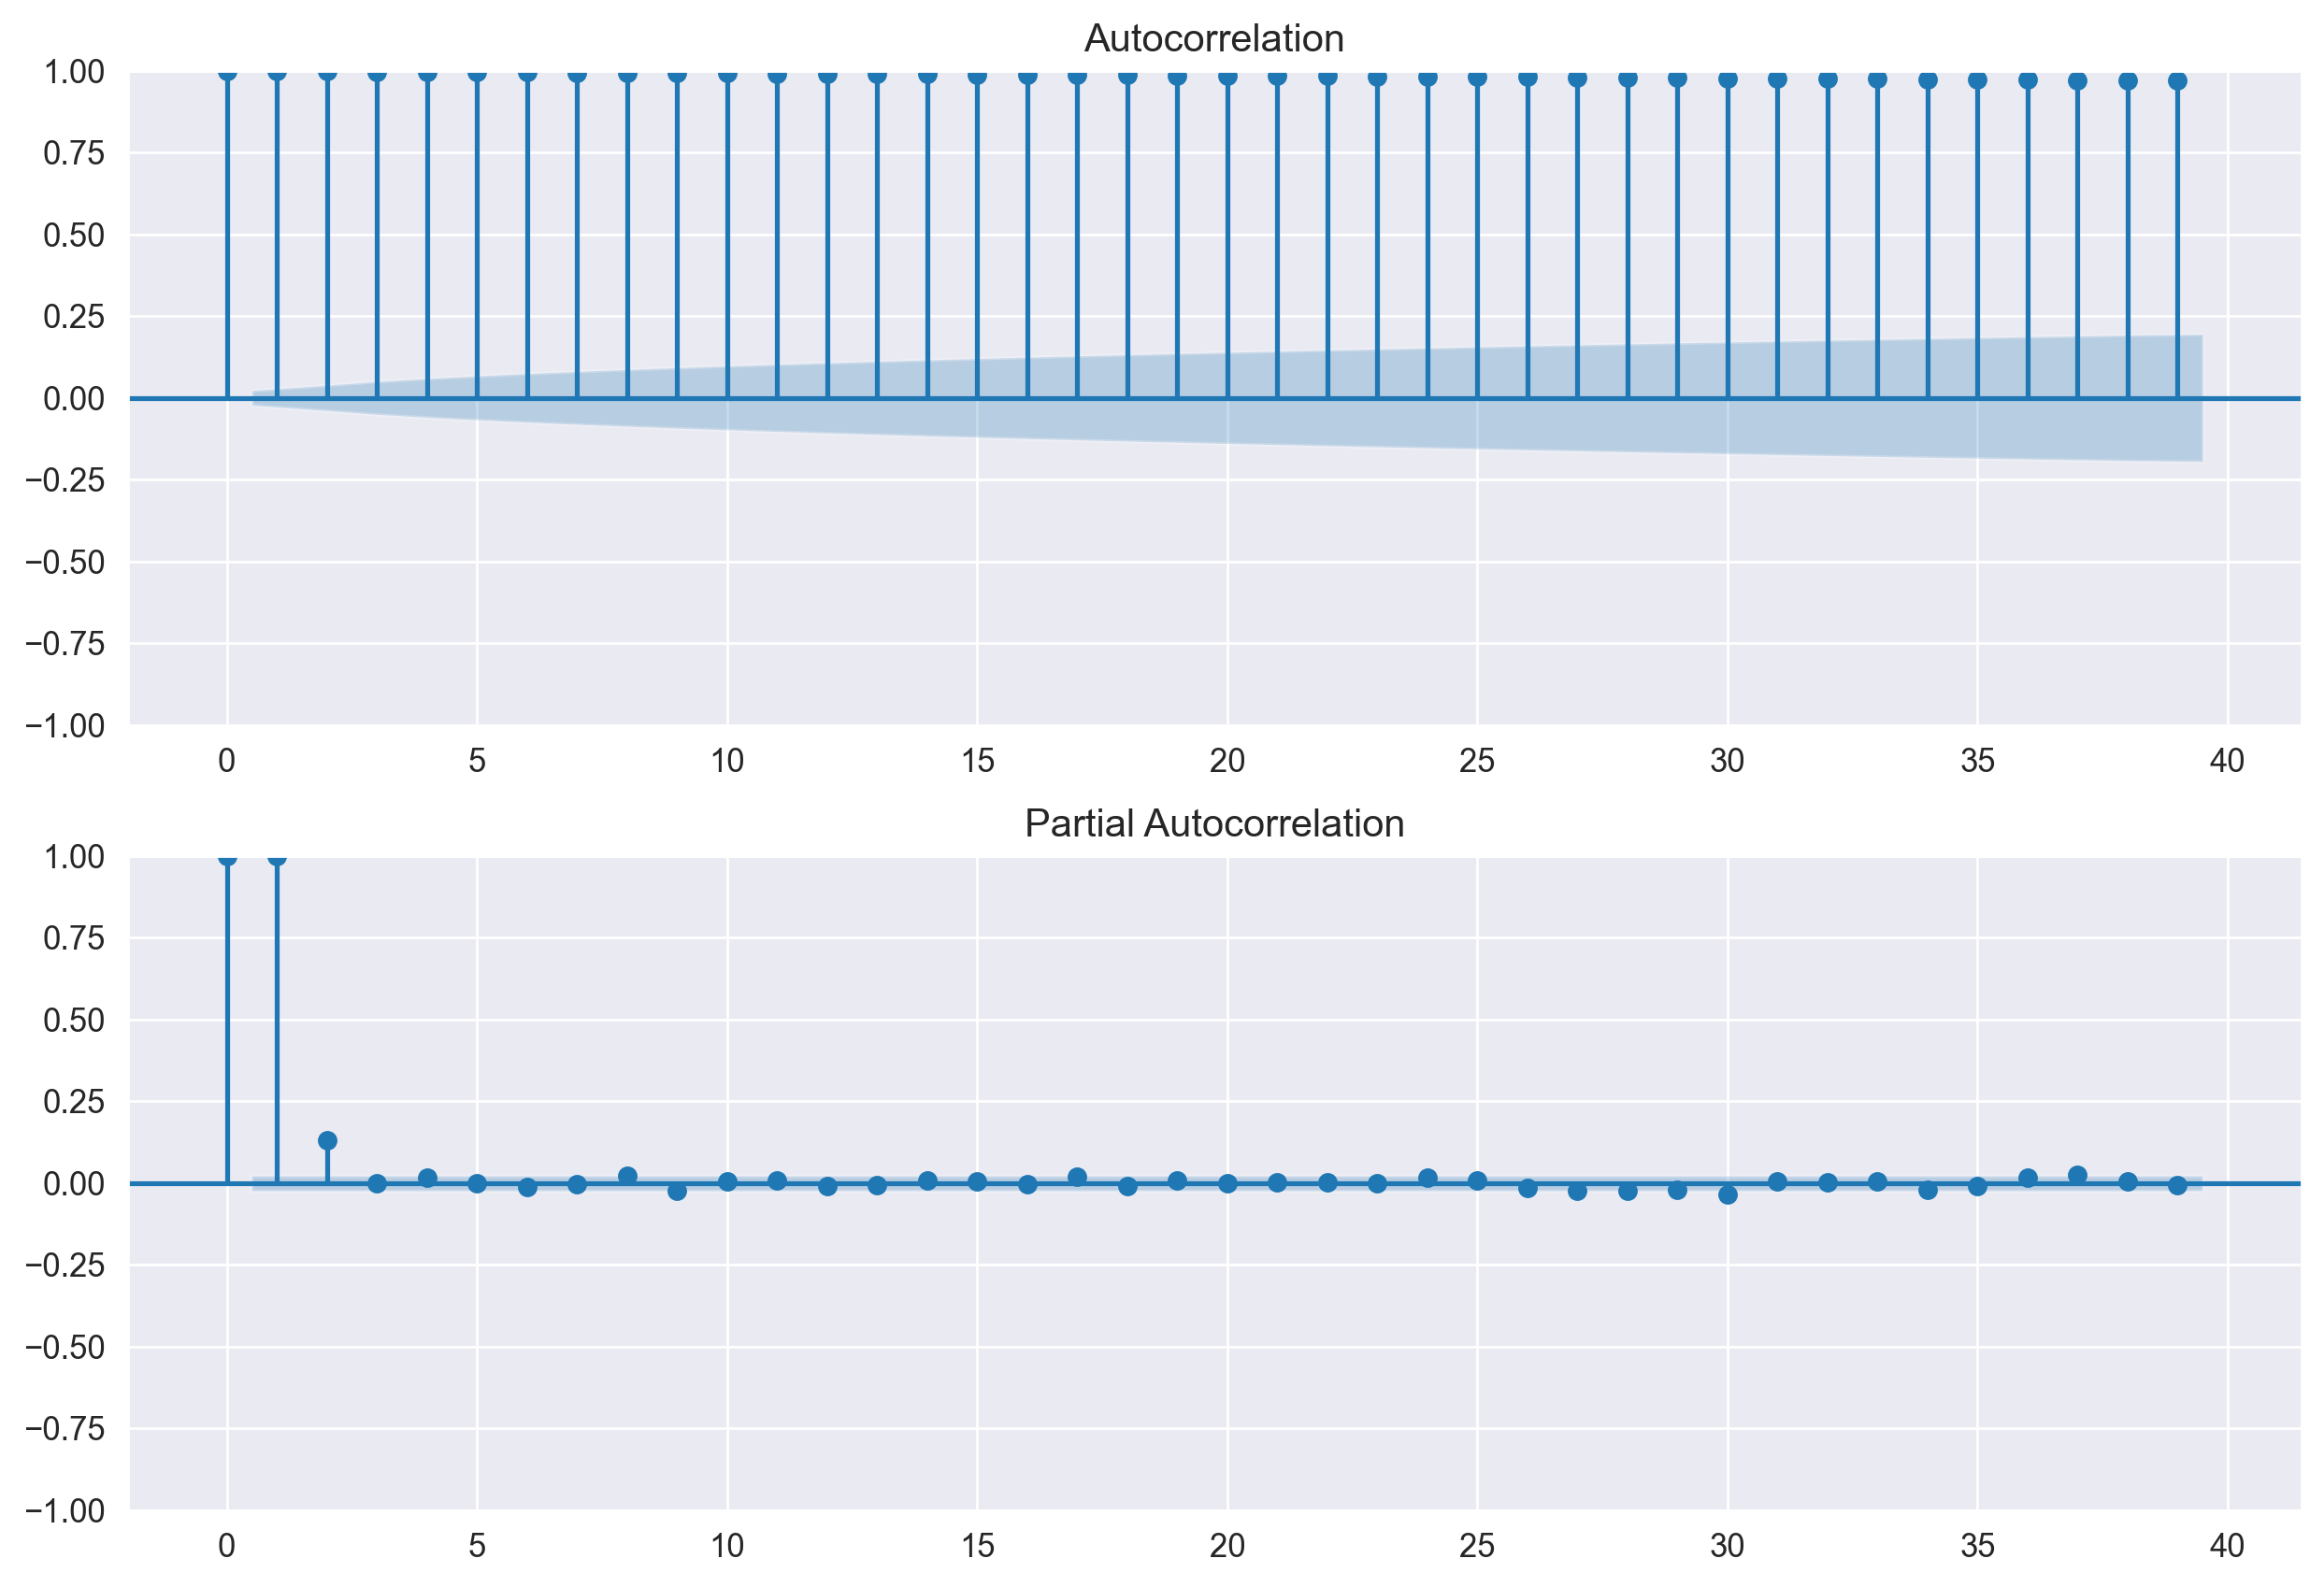

In [8]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Ex_rate'], ax=ax[0])
plot_pacf(df['Ex_rate'], ax=ax[1])
plt.show()

2. Model Fitting

In [9]:
# Define the ARIMA model
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))  # Example order, adjust based on ACF/PACF
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 04 Aug 2024   AIC                         -56102.322
Time:                        13:54:23   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

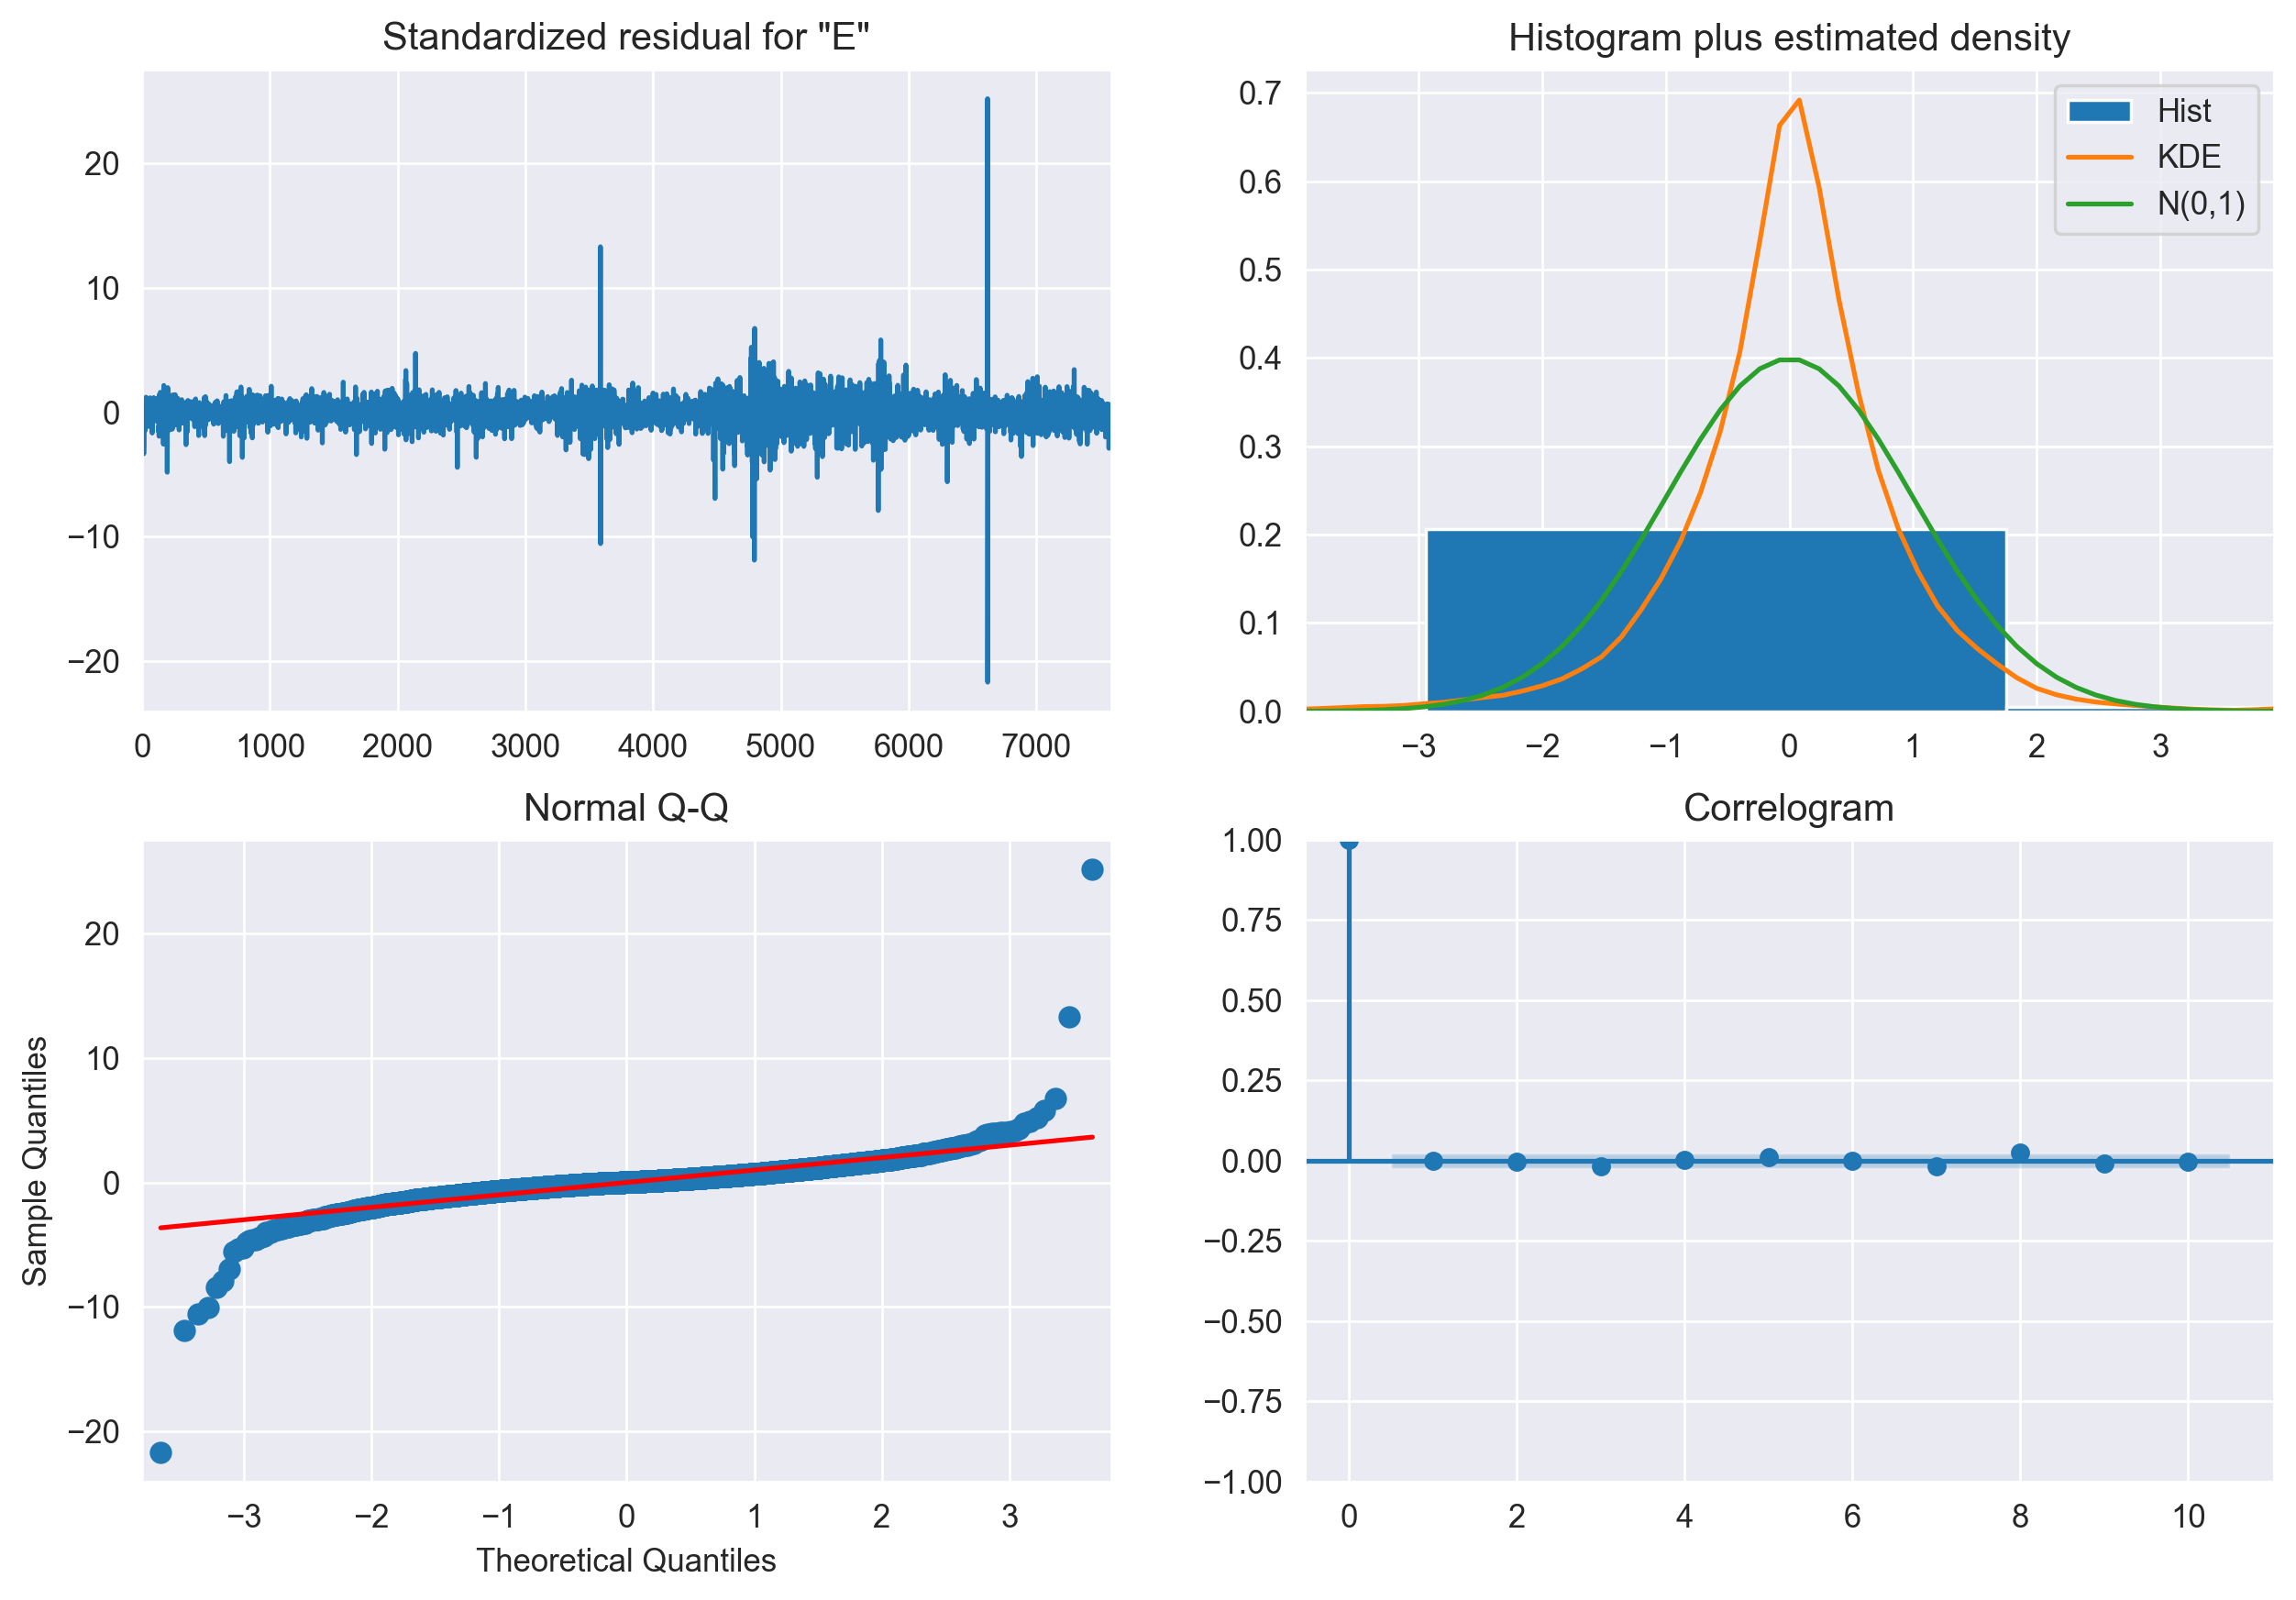

In [10]:
# Plot diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [11]:
# Forecast future values
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1], periods=30, freq='D')
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Part 3: Model Building - Exponential Smoothing
1. Model Selection

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define the Exponential Smoothing model
model_es = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)

2. Parameter Optimization

In [13]:
# Fit the model
model_es_fit = model_es.fit(optimized=True)

# Summary of the model
print(model_es_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77624.575
Trend:                         Additive   BIC                         -77513.626
Seasonal:                      Additive   AICC                        -77624.485
Seasonal Periods:                    12   Date:                 Sun, 04 Aug 2024
Box-Cox:                          False   Time:                         13:54:25
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8702083                alpha                 True
smoothing_trend          

3. Model Fitting and Forecasting

In [ ]:
# Forecast future values
forecast_es = model_es_fit.forecast(steps=30)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(forecast_es.index, forecast_es, label='Forecast', color='red')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()

# Part 4: Evaluation and Comparison

1. Compute Error Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Compute error metrics for ARIMA
y_true = df['Ex_rate'][-30:]  # Actual values for the same forecast period
y_pred_arima = forecast_values[:30]  # Predicted values

mae_arima = mean_absolute_error(y_true, y_pred_arima)
rmse_arima = mean_squared_error(y_true, y_pred_arima, squared=False)

In [ ]:
# Compute error metrics for Exponential Smoothing
y_pred_es = forecast_es[:30]  # Predicted values

mae_es = mean_absolute_error(y_true, y_pred_es)
rmse_es = mean_squared_error(y_true, y_pred_es, squared=False)

print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}')
print(f'Exponential Smoothing MAE: {mae_es}, RMSE: {rmse_es}')

In [ ]:
#Conclusion

#1. ARIMA Model:
   #The ARIMA model showed [specific trend] in forecasting with an MAE of {mae_arima} and RMSE of {rmse_arima}.
   #Advantages: [list advantages].
   #Limitations: [list limitations].

#2. Exponential Smoothing Model:
   #The Exponential Smoothing model showed [specific trend] in forecasting with an MAE of {mae_es} and RMSE of {rmse_es}.
   #Advantages: [list advantages].
   #Limitations: [list limitations].

#Based on the error metrics and visual inspection of the forecasts, [model name] provided better performance for forecasting exchange rates in this dataset.